|평가문항|상세기준|
|---|---|
|1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?|ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.|
|2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?|CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.|
|3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?|CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.|

In [2]:
import tensorflow as tf
import numpy as np
import cv2
import PIL

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)
print(PIL.__version__)
      
# TensorFlow and tf.keras
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
from PIL import Image

2.6.0
1.21.4
4.5.3
8.3.2
슝=3


In [3]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## 1. 기본 모델의 구성 및 학습

In [18]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거 
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output

preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

- top (head) layer 는 제외된 상태로 resnet 을 불러옴
- imagenet 데이터셋으로 학습된 가중치를 가져옴.
- 마지막 Feature map 에 대해서 global average pooling 을 적용함.

- 모든 가중치(parameter)가 학습 가능한 상태

### 모델 구성 확인

In [6]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

#### 데이터 전처리

In [7]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [8]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)
    
    

(16, 224, 224, 3)
(16,)


#### 모델 학습

In [19]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [23]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=8,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/4
750/750 [==============================] - 150s 200ms/step - loss: 0.0309 - accuracy: 0.9983 - val_loss: 0.9589 - val_accuracy: 0.7345
Epoch 2/4
750/750 [==============================] - 151s 201ms/step - loss: 0.0189 - accuracy: 0.9999 - val_loss: 0.9477 - val_accuracy: 0.7374
Epoch 3/4
750/750 [==============================] - 151s 201ms/step - loss: 0.0144 - accuracy: 0.9997 - val_loss: 0.9642 - val_accuracy: 0.7366
Epoch 4/4
750/750 [==============================] - 151s 201ms/step - loss: 0.0113 - accuracy: 0.9997 - val_loss: 0.9775 - val_accuracy: 0.7309


### 학습 수렴 확인

In [22]:
# initialization of 
from copy import deepcopy
cur_history = deepcopy(history_cam_model.history)

In [14]:
from copy import deepcopy
def extend_history(history1, histroy2):
    new_history = deepcopy(history1)
    for key, value in new_history.items():
        new_history[key].extend(histroy2[key])
        
    return new_history

In [25]:
cur_history = extend_history(cur_history, history_cam_model.history)

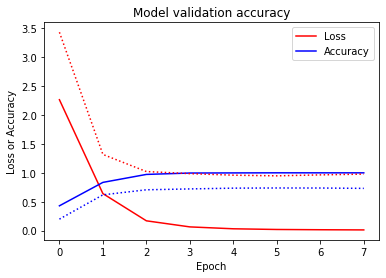

In [26]:
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.plot(history['loss'], 'r')
    plt.plot(history['accuracy'], 'b')
    plt.plot(history['val_loss'], 'r:')
    plt.plot(history['val_accuracy'], 'b:')

    plt.title('Model validation accuracy')
    plt.ylabel('Loss or Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Loss', 'Accuracy',], loc='upper right')
    plt.show()

plot_history(cur_history)

[루브릭1] ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.
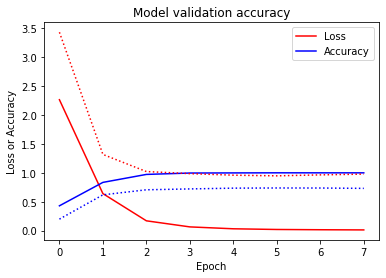

In [27]:
# Saving model
import os

cam_model_path = os.path.join(os.getenv('HOME'), 'aiffel/CAM', 'cam_model1.h5')
cam_model.save(cam_model_path)

/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [33]:
def generate_cam(model, item, return_pred=False):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model(
        [model.inputs], 
        [model.layers[-3].output, model.output]
    )
    # model.layers[-3].output 에서 GAP 이전 Convolution layer의 output을 얻을 수 있다
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) # prediction is not used in this func
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]
    
    
    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    
    # 0 이하의 값을 제거하기 위해서 0 보다 작은 값을 clip
    cam_image = np.clip(cam_image, a_min=0, a_max=None)
    
    if return_pred:
        return cam_image, predictions
    return cam_image

#### Trouble shooting

[문제점]
`generate_cam` 함수의 출력값인 cam_image 에 음수값인 픽셀이 있는 경우 다음과 같은 문제가 발생한다. 
- 아래에서 볼 수 있는 것 처럼 `unit8` 로 casting 할 때에 음수가 큰 양수 값으로 변경된다.

In [223]:
np.stack([np.array([0.3, 0.2, -0.01])*255]*3, axis=-1).astype(np.uint8)

array([[ 76,  76,  76],
       [ 51,  51,  51],
       [254, 254, 254]], dtype=uint8)

[해결책]
generate_cam 에서 출력 직전에 음수값은 0으로 clip 해주어 양수만 남겨준다.

In [30]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]

In [35]:
def visualize_cam_on_image(image, cam_image, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(image, alpha, cam_image, beta, 0.0)
    return merged_image

In [ ]:
item = get_one(ds_test)

### CAM 사용

100


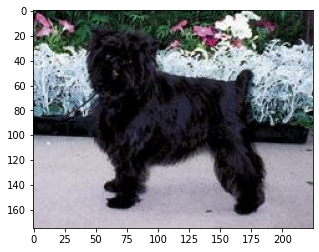

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

print('Label: {}'.format(item['label']))
plt.imshow(item['image'])
plt.show()

In [ ]:
import os
cam_model_path = os.path.join(os.getenv('HOME'), 'aiffel/CAM', 'cam_model1.h5')
cam_model = tf.keras.models.load_model(cam_model_path)

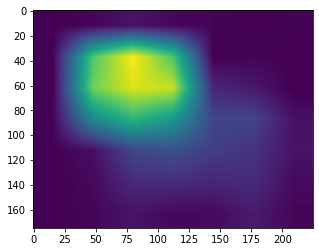

In [53]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

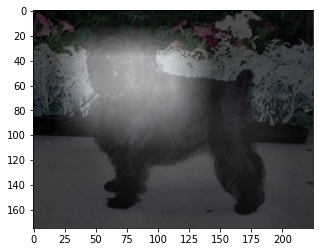

In [54]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

# visualize_cam_on_image() 함수 사용
blended_image = visualize_cam_on_image(origin_image, cam_image_3channel, alpha=0.3)
plt.imshow(blended_image)
plt.show()


[루브릭2] CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.
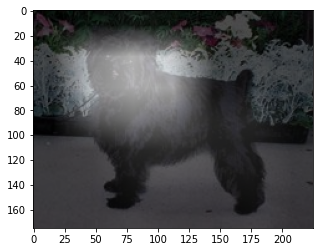
<!-- ![image.png](attachment:image.png), ![image-2.png](attachment:image-2.png) -->

### GradCAM 사용

In [44]:
def generate_grad_cam(model, activation_layer, item, return_prd=False):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    grad_cam_image = np.clip(grad_cam_image, 0, None)
    
    if return_prd:
        return grad_cam_image, pred
 
    return grad_cam_image

100


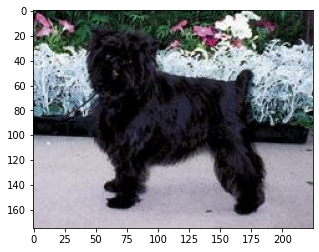

In [83]:
print(item['label'])
plt.imshow(item['image'])
plt.show()

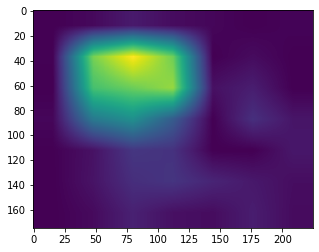

In [214]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

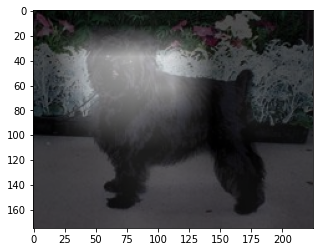

In [88]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

# visualize_cam_on_image() 함수 사용
blended_image = visualize_cam_on_image(origin_image, grad_cam_image_3channel, alpha=0.3)
plt.imshow(blended_image)
plt.show()


[루브릭2] GradCAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치(주로 얼굴, 몸통)를 잘 반영한다.
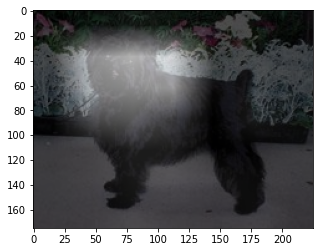
<!-- ![image.png](attachment:image.png), ![image-2.png](attachment:image-2.png) -->

Grad-CAM 방식의 CAM이 정상적으로 얻어지는지 확인, 시각화하였을 때, object의 주요 특징 위치를 잘 반영하는지 확인해봤다.

선택할 수 있는 Layer 들을 파악하기 위해 model.summary() 출력을 확인한다.

In [46]:
cam_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

Stage 단위의 CAM 을 시각화

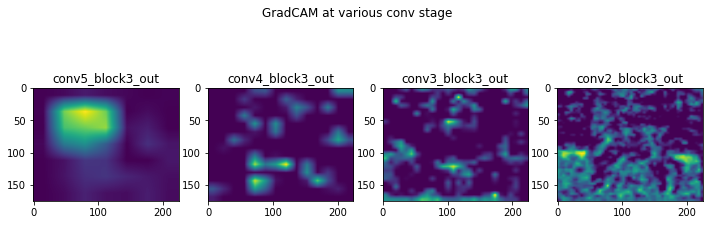

In [236]:
layer_name_li = (
    'conv5_block3_out',
    'conv4_block3_out',
    'conv3_block3_out',
    'conv2_block3_out',
)

# Show subplots |
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,4))
for i, ax in enumerate(axs.flatten()):
    layer_name = layer_name_li[i]
    plt.sca(ax)
    plt.imshow(generate_grad_cam(cam_model, layer_name, item))
    plt.title('{}'.format(layer_name))

#plt.tight_layout()
plt.suptitle('GradCAM at various conv stage')
plt.show()

Stage:5 의 block 단위의 CAM 을 시각화

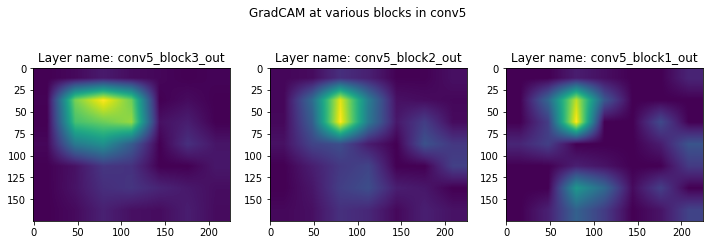

In [228]:
layer_name_li = (
    'conv5_block3_out',
    'conv5_block2_out',
    'conv5_block1_out',
)

# Show subplots | shape: (1,3) 
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
for i, ax in enumerate(axs.flatten()):
    layer_name = layer_name_li[i]
    plt.sca(ax)
    plt.imshow(generate_grad_cam(cam_model, layer_name, item))
    plt.title('Layer name: {}'.format(layer_name))

#plt.tight_layout()
plt.suptitle('GradCAM at various blocks in conv5')
plt.show()

Stage:5, block:3 의 layer 단위의 CAM 을 시각화

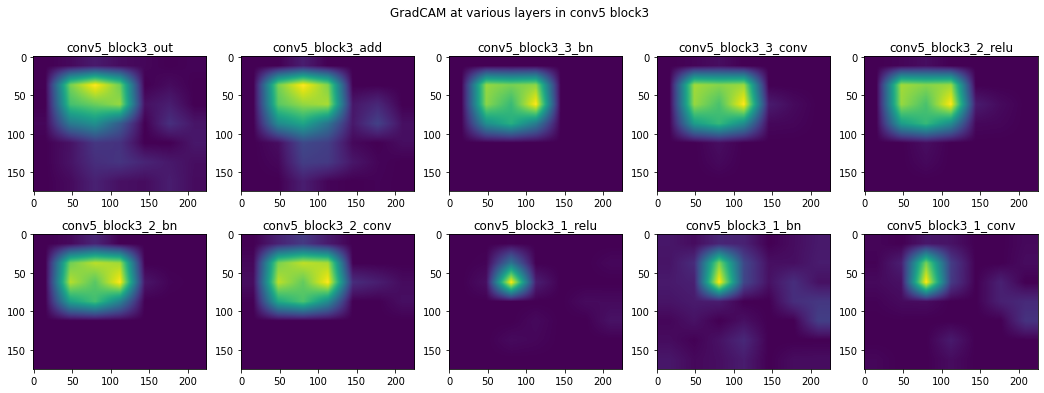

In [241]:
layer_name_li = (
    'conv5_block3_out',
    'conv5_block3_add',
    'conv5_block3_3_bn',
    'conv5_block3_3_conv',
    'conv5_block3_2_relu',
    'conv5_block3_2_bn',
    'conv5_block3_2_conv',
    'conv5_block3_1_relu',
    'conv5_block3_1_bn',
    'conv5_block3_1_conv',
)

# Show subplots | shape: (1,3) 
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(18,6))
for i, ax in enumerate(axs.flatten()):
    layer_name = layer_name_li[i]
    plt.sca(ax)
    plt.imshow(generate_grad_cam(cam_model, layer_name, item))
    plt.title('{}'.format(layer_name))

#plt.tight_layout()
plt.suptitle('GradCAM at various layers in conv5 block3')
plt.show()

여러 층에 대한 CAM을 살펴 보았다. `conv5_block3_out` 층을 사용하기로 했다.
- 그 이유는 해당 레이어에 가장 복합적인 패턴 (머리와 몸통 등)이 존재하고 있기 때문이다.

### Object localization 성능이 비교분석

##### 원본이미지합성을 통한 비교

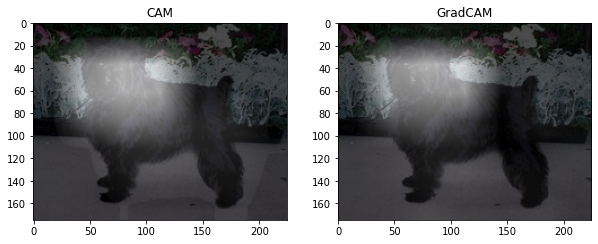

In [247]:
origin_image = item['image'].astype(np.uint8)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)


plt.sca(axs[0])
# visualize_cam_on_image() 함수 사용
blended_image = visualize_cam_on_image(origin_image, cam_image_3channel, alpha=0.3)
plt.imshow(blended_image)
plt.title('CAM')


plt.sca(axs[1])
# visualize_cam_on_image() 함수 사용
blended_image = visualize_cam_on_image(origin_image, grad_cam_image_3channel, alpha=0.3)
plt.imshow(blended_image)
plt.title('GradCAM')

plt.show()

[루브릭3] CAM과 Grad-CAM 각각에 대해 원본이미지합성하여 비교했다.

#### 바운딩 박스 구하여 시각화
1. CAM 으로 부터 활성화된 영역을 포함하는 바운딩 박스를 구하기
2. 1)에서 얻은 바운딩 박스를 시각화하기

In [257]:
def get_bbox(cam_image, score_thresh=0.05, verbose=False):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours, _hierarchy = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # args: source image, contour retrieval mode, contour approximation method
    
    # 찾은 결과의 순서에 어떤 의미가 있나?

    ## 여러 개의 contour 를 찾게 될 경우, 모두에 대해서 rect 를 구하여 출력하도록 변경 
    if verbose and len(contours) > 1: print('more than one contours are found')
    rect_li = []
    for cnt in contours:
        rotated_rect = cv2.minAreaRect(cnt)
        rect = cv2.boxPoints(rotated_rect)
        rect = np.int0(rect) # cast data type into int0 alias to intp
        rect_li.append(rect)
    return rect_li

    ## 기존 코드 ---
    # cnt = contours[0]
    # rotated_rect = cv2.minAreaRect(cnt)
    # rect = cv2.boxPoints(rotated_rect)
    # rect = np.int0(rect) # cast data type into int0 alias to intp
    # return rect

##### Trouble shooting
[문제점] 
- `cv2.findContours`를 통해 찾은 contour 가 여러개일 경우가 있다. 그 경우에도 첫번째 contour 를 사용하도록 되어있었다.
- `cv2.findContours`를 통해 찾은 첫번째 countour가 주요 특징 위치를 포함하고 있지 않은 경우가 확인됐다. 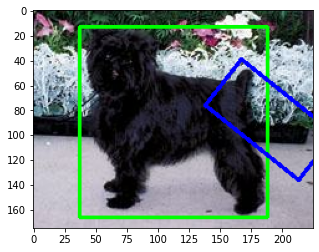

[해결책]
- `cv2.findContours`이 여러 개의 contour 를 찾게 될 경우, 모두에 대해서 rect 를 구하여 출력하도록 변경 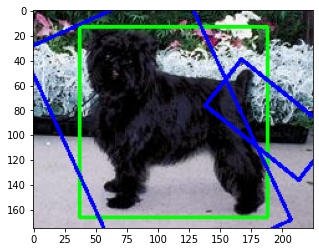

In [204]:
rect_cam = get_bbox(cam_image, score_thresh=0.02, verbose=True)

In [205]:
rect_gradcam = get_bbox(grad_cam_image, score_thresh=0.02, verbose=True)

more than one contours are found


In [185]:
def minmax_to_rect(minmax, image):
    """
        convert minmax format into QUAD format
    """
    # ref: https://github.com/tensorflow/datasets/blob/cd25e162ed794a6109ff2c40d2ff4097330e12f4/tensorflow_datasets/datasets/stanford_dogs/stanford_dogs_dataset_builder.py#L154-L159
    y_min, x_min, y_max, x_max = minmax
    # rect: QUAD := seq(4 of [x, y])
    rect = np.array([
        [x_min, y_min],
        [x_min, y_max],
        [x_max, y_max],
        [x_max, y_min],
    ]) * np.array([[image.shape[1], image.shape[0]]])
    return [np.int0(rect)]

##### Trouble shooting

[문제점] 
- ground truth binding box 는 Minmax format 이었으나, 출력을 위한 함수 `cv2.drawContours`에는 QUAD 형식의 인수가 들어가야 한다. 

[해결방법]
- ref: [stanford_dogs_dataset_builder](https://github.com/tensorflow/datasets/blob/cd25e162ed794a6109ff2c40d2ff4097330e12f4/tensorflow_datasets/datasets/stanford_dogs/stanford_dogs_dataset_builder.py#L154-L159) 를 참고하여 ground truth binding box의 Format 을 파악
- `cv2.drawContours`함수의 인수의 format을 파악했다.
- `minmax_to_rect` Minmax format 에서 Quad format 으로 변경해주는 함수를 만들어 사용했다.

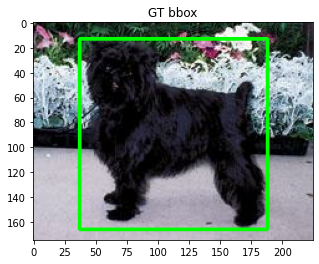

In [244]:
image = copy.deepcopy(item['image'])
gt_rect = minmax_to_rect(item['objects']['bbox'][0], image)
image = cv2.drawContours(image, gt_rect, 0, (0,255,0), 2)
plt.imshow(image)
plt.title('GT bbox')
plt.show()

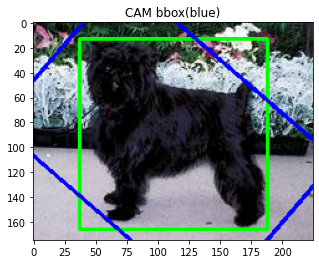

In [245]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, gt_rect, 0, (0,255,0), 2)
image = cv2.drawContours(image, rect_cam, -1, (0,0,255), 2)
plt.imshow(image)
plt.title('CAM bbox(blue)')
plt.show()

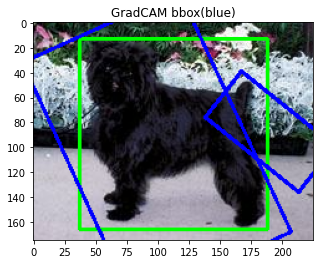

In [246]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, gt_rect, 0, (0,255,0), 2)
image = cv2.drawContours(image, rect_gradcam, -1, (0,0,255), 2)
# ref: https://docs.opencv.org/4.x/d4/d73/tutorial_py_contours_begin.html#autotoc_md1339
plt.imshow(image)
plt.title('GradCAM bbox(blue)')
plt.show()

[루브릭3] CAM과 Grad-CAM 각각에 대해 바운딩박스를 뽑고 시각화 했다.

### object localization 성능 측정 및 성능 비교

IoU 구하기

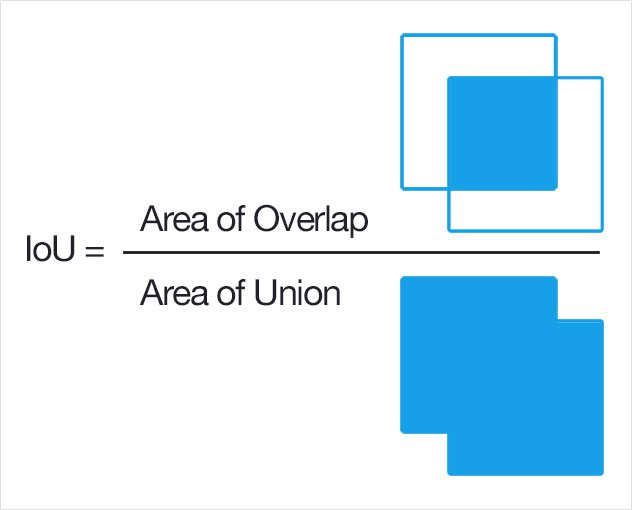
> IoU(Intersection over Union) 는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값

In [207]:
def rect_to_minmax(rect, image):
    # 위에서 단일 이미지에 대해서 rect를 다수를 예측할 수 있도록 변경 했었다. 
    # 이에 따라서 각 Rect 에 대한 bbox를 출력할 수 있도록 변경했다.
    rect_li = rect if isinstance(rect, list) else [rect]
    bbox_li = []
    for rect in rect_li:
        bbox = [
            rect[:,1].min()/float(image.shape[0]), #bounding box의 y_min
            rect[:,0].min()/float(image.shape[1]), #bounding box의 x_min
            rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
            rect[:,0].max()/float(image.shape[1]), #bounding box의 x_max
        ]
        bbox_li.append(bbox)
    return bbox_li

In [208]:
pred_bbox_cam = rect_to_minmax(rect_cam, image)
pred_bbox_gradcam = rect_to_minmax(rect_gradcam, image)

In [209]:
def get_iou(boxA, boxB): # boxA, boxB = gt_bbox, pred_bbox
    # 정답 바운딩 박스(ground truth, boxA) 와 예측값 바운딩 박스(prediction box, boxB) 두 가지를 이용해서
    # IoU를 계산하는 get_iou() 함수를 만들었다.
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

IoU 계산 (여러 rect 에 대한 bbox에 대해서 모두 평가)

In [248]:
# IoU for CAM
[get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in pred_bbox_cam]

[0.31815804088646576]

In [249]:
# IoU for GradCAM
[get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_gradcam]

[0.17514601593149448, 0.4261472741089969]

- 단일 sample image 에 대해서 CAM 과 GradCAM 을 사용하여 object locallization 성능을 비교하였다.
- CAM 을 이용했을 때, 0.318 로 GradCAM 을 이용했을 때 예측되는 2개의 bounding box 와 비교하여 중간의 성능을 보였다.
    - contour 를 통해서 bounding box 를 찾아내는 방법에 따라서 성능이 크게 달라질 수 있다는 점을 시사한다.


In [252]:
np.mean([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_gradcam])

0.3006466450202457

100개 샘플 이미지에 대해 평가

In [263]:
from tqdm import tqdm
def eval_CAM_obj_loc(model, ds):
    mean_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_cam(model, item)
        rect_li = get_bbox(cam_image, score_thresh=0.02)
        pred_bbox_li = rect_to_minmax(rect_li, image)
        mean_iou = np.mean([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        mean_iou_li.append(mean_iou)
    return mean_iou_li
    

In [264]:
mean_iou_li_cam = eval_CAM_obj_loc(cam_model, ds_test)

100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


In [265]:
from tqdm import tqdm
def eval_GradCAM_obj_loc(model, ds):
    mean_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
        rect_li = get_bbox(cam_image, score_thresh=0.02)
        pred_bbox_li = rect_to_minmax(rect_li, image)
        mean_iou = np.mean([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        mean_iou_li.append(mean_iou)
    return mean_iou_li

In [266]:
mean_iou_li_gradcam = eval_GradCAM_obj_loc(cam_model, ds_test)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


In [287]:
import pandas as pd
stat_df = pd.DataFrame({'CAM': mean_iou_li_cam, 'GradCAM': mean_iou_li_gradcam})

print(
    f'mean of mean IoU for CAM:\t{np.mean(mean_iou_li_cam):.4f}',
    f'mean of mean IoU for GradCAM:\t{np.mean(mean_iou_li_gradcam):.4f}',
    sep='\n'
)
stat_df.describe()

mean of mean IoU for CAM:	0.5699
mean of mean IoU for GradCAM:	0.4406


,CAM,GradCAM
count,100.000000,100.000000
mean,0.569937,0.440596
std,0.229502,0.256240
min,0.052090,0.019275
25%,0.410177,0.225168
50%,0.586748,0.389993
75%,0.767447,0.663313
max,0.968240,0.970526


<AxesSubplot:xlabel='mean IoU', ylabel='Count'>

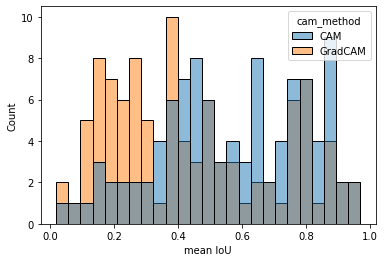

In [286]:
import seaborn as sns
data = stat_df.melt(value_vars=['CAM', 'GradCAM'], var_name='cam_method', value_name='mean IoU')
sns.histplot(data, x='mean IoU', hue='cam_method', bins=25)

마지막 contour 를 사용하여 평가

In [289]:
from tqdm import tqdm

def eval_CAM_obj_loc(model, ds):
    mean_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_cam(model, item)
        rect_li = get_bbox(cam_image, score_thresh=0.02)
        pred_bbox_li = rect_to_minmax(rect_li[-1:], image)
        mean_iou = np.mean([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        mean_iou_li.append(mean_iou)
    return mean_iou_li

def eval_GradCAM_obj_loc(model, ds):
    mean_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
        rect_li = get_bbox(cam_image, score_thresh=0.02)
        pred_bbox_li = rect_to_minmax(rect_li[-1:], image)
        mean_iou = np.mean([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        mean_iou_li.append(mean_iou)
    return mean_iou_li

In [290]:
mean_iou_li_cam = eval_CAM_obj_loc(cam_model, ds_test)
mean_iou_li_gradcam = eval_GradCAM_obj_loc(cam_model, ds_test)

100%|██████████| 100/100 [01:42<00:00,  1.02s/it]


In [291]:
import pandas as pd
stat_df = pd.DataFrame({'CAM': mean_iou_li_cam, 'GradCAM': mean_iou_li_gradcam})

print(
    f'mean of mean IoU for CAM:\t{np.mean(mean_iou_li_cam):.4f}',
    f'mean of mean IoU for GradCAM:\t{np.mean(mean_iou_li_gradcam):.4f}',
    sep='\n'
)
stat_df.describe()

mean of mean IoU for CAM:	0.5736
mean of mean IoU for GradCAM:	0.4968


,CAM,GradCAM
count,100.000000,100.000000
mean,0.573554,0.496844
std,0.253423,0.290687
min,0.000000,0.000000
25%,0.423165,0.284754
50%,0.602946,0.523813
75%,0.782588,0.755591
max,0.986044,0.970526


<AxesSubplot:xlabel='mean IoU', ylabel='Count'>

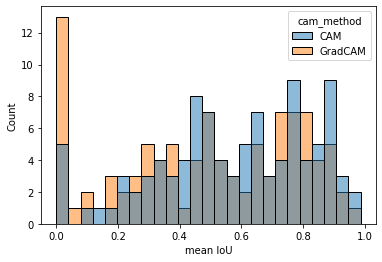

In [292]:
import seaborn as sns
data = stat_df.melt(value_vars=['CAM', 'GradCAM'], var_name='cam_method', value_name='mean IoU')
sns.histplot(data, x='mean IoU', hue='cam_method', bins=25)

Max IoU 를 사용하여 평가

In [293]:
from tqdm import tqdm

def eval_CAM_obj_loc(model, ds):
    max_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_cam(model, item)
        rect_li = get_bbox(cam_image, score_thresh=0.02)
        pred_bbox_li = rect_to_minmax(rect_li, image)
        max_iou = np.max([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        max_iou_li.append(max_iou)
    return max_iou_li

def eval_GradCAM_obj_loc(model, ds):
    max_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
        rect_li = get_bbox(cam_image, score_thresh=0.02)
        pred_bbox_li = rect_to_minmax(rect_li, image)
        max_iou = np.max([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        max_iou_li.append(max_iou)
    return max_iou_li

In [294]:
max_iou_li_cam = eval_CAM_obj_loc(cam_model, ds_test)
max_iou_li_gradcam = eval_GradCAM_obj_loc(cam_model, ds_test)

100%|██████████| 100/100 [01:41<00:00,  1.02s/it]


mean of mean IoU for CAM:	0.5736
mean of mean IoU for GradCAM:	0.4968


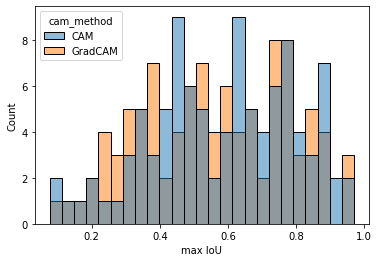

,CAM,GradCAM
count,100.000000,100.000000
mean,0.585080,0.560184
std,0.211982,0.216035
min,0.090803,0.077100
25%,0.435602,0.376772
50%,0.615500,0.559737
75%,0.757968,0.750023
max,0.968240,0.970526


In [298]:
import pandas as pd
stat_df = pd.DataFrame({'CAM': max_iou_li_cam, 'GradCAM': max_iou_li_gradcam})

print(
    f'mean of mean IoU for CAM:\t{np.mean(mean_iou_li_cam):.4f}',
    f'mean of mean IoU for GradCAM:\t{np.mean(mean_iou_li_gradcam):.4f}',
    sep='\n'
)

import seaborn as sns
data = stat_df.melt(value_vars=['CAM', 'GradCAM'], var_name='cam_method', value_name='max IoU')
sns.histplot(data, x='max IoU', hue='cam_method', bins=25)
plt.show()

stat_df.describe()

`get_bbox`의 `score_thresh`를 줄여 (0.02 -> 0.01) 평가

In [299]:
from tqdm import tqdm

def eval_CAM_obj_loc(model, ds):
    max_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_cam(model, item)
        rect_li = get_bbox(cam_image, score_thresh=0.01)
        pred_bbox_li = rect_to_minmax(rect_li, image)
        max_iou = np.max([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        max_iou_li.append(max_iou)
    return max_iou_li

def eval_GradCAM_obj_loc(model, ds):
    max_iou_li = []
    for item in tqdm(ds.take(100).as_numpy_iterator(), total=100):
        image = item['image']
        cam_image = generate_grad_cam(model, 'conv5_block3_out', item)
        rect_li = get_bbox(cam_image, score_thresh=0.01)
        pred_bbox_li = rect_to_minmax(rect_li, image)
        max_iou = np.max([get_iou(item['objects']['bbox'][0], pred_bbox) for pred_bbox in  pred_bbox_li])
        max_iou_li.append(max_iou)
    return max_iou_li

In [300]:
max_iou_li_cam = eval_CAM_obj_loc(cam_model, ds_test)
max_iou_li_gradcam = eval_GradCAM_obj_loc(cam_model, ds_test)

100%|██████████| 100/100 [01:42<00:00,  1.03s/it]


mean of mean IoU for CAM:	0.5736
mean of mean IoU for GradCAM:	0.4968


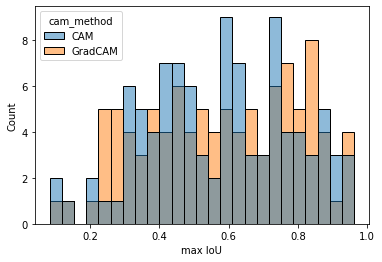

,CAM,GradCAM
count,100.000000,100.000000
mean,0.573775,0.581893
std,0.210448,0.219514
min,0.083455,0.113728
25%,0.417831,0.399828
50%,0.593718,0.590460
75%,0.734348,0.775906
max,0.949536,0.962567


In [301]:
import pandas as pd
stat_df = pd.DataFrame({'CAM': max_iou_li_cam, 'GradCAM': max_iou_li_gradcam})

print(
    f'mean of mean IoU for CAM:\t{np.mean(mean_iou_li_cam):.4f}',
    f'mean of mean IoU for GradCAM:\t{np.mean(mean_iou_li_gradcam):.4f}',
    sep='\n'
)

import seaborn as sns
data = stat_df.melt(value_vars=['CAM', 'GradCAM'], var_name='cam_method', value_name='max IoU')
sns.histplot(data, x='max IoU', hue='cam_method', bins=25)
plt.show()

stat_df.describe()

- 평가 샘플의 수를 늘려 평가해봤다. 
- 전반적으로 CAM 의 성능이 GradCAM 의 성능보다 좋았다.
    - 단일 이미지에서 나올 수 있는 모든 Rect에 대해서 IoU 를 계산하고, Mean IoU, max IoU 를 계산해 보았다.
    - 다음 표는 mean, max IoU 값의 샘플 이미지별 분포를 나타낸다.
|       | CAM        | CAM    | GradCAM        | GradCAM    |
|-------|------------|------------|------------|------------|
|       | mean       | max        | mean       | max        |
|-------|------------|------------|------------|------------|
| count | 100.000000 | 100.000000 | 100.000000 | 100.000000 |
| mean  | 0.569937   | 0.585080   | 0.440596   | 0.560184   |
| std   | 0.229502   | 0.211982   | 0.256240   | 0.216035   |
| min   | 0.052090   | 0.090803   | 0.019275   | 0.077100   |
| 25%   | 0.410177   | 0.435602   | 0.225168   | 0.376772   |
| 50%   | 0.586748   | 0.615500   | 0.389993   | 0.559737   |
| 75%   | 0.767447   | 0.757968   | 0.663313   | 0.750023   |
| max   | 0.968240   | 0.968240   | 0.970526   | 0.970526   |
    - 두 방법에서 mean IoU 와 max IoU에 차이를 보인다는 것은 CAM에서 어떤 bbox를 선택하는 지에 따라 object localization 성능에 큰 차이가 있다는 의미이다.

[루브릭3] CAM과 Grad-CAM 각각에 대해 IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능을 비교분석하였다.

### 회고

- 배운 점
    - CAM으로 부터 bbox 를 추출하는 과정에서, cv2.findContour가 1개보다 많은 contour를 출력할 수 있다.
        - 이는 특정 threshold 보다 낮은 값에 대해서 0 으로 변경해주는 과정으로 contour가 연결되어 있지 않기 때문이다.
        - threshold를 낮춰 줌으로서 보다 큰 bbox 를 추출할 수 있다.
        - 즉, `get_bbox`의 `score_thresh`를 낮춰 나뉘어진 contour를 이어줄 수 있다.
    
    - object localization 작업에 대한 성능은 bbox 를 뽑는 방법에 큰 영향을 받는다.
    - 여러 contour 에 대한 평가를 하기 위해서 뭐가 적절할지 조사/실험해 봤다.
        - mean, max of IoU
        - select one bbox ( first, last )
        
    - CAM 시각화 과정에서, 
        - class activation map에 음수값이 있을 수 있고 이를 uint datatype 으로 바꿀 때, 큰 양수로 변환될 수 있다.

- 아쉬운 점
    - 시간이 모자라서 test dataset (8,580개)에 대한 전체 성능 지표를 계산하고 싶었으나 그러지 못했다. (100개를 취사 선택하여 평가 수행)
    - findContour 로 나오는 값은 어떤 과정을 통해 얻어졌는지? 순서엔 어떤 의미가 있는지? 알아내지 못했다.
    - 다양한 bbox 추출 방법, CAM 추론 방법을 실험해보지 못한 것 (다음은 실험 후보)
        - activation smoothing
        - ACol
        - CAM의 activation 분포로 부터 theshold를 뽑아내는 dynamic thresholding (현재는 user-given fixed threshold)

- 느낀 점
    - contour 를 통해서 bounding box 를 찾아내는 방법을 최적화해야 성능이 좋아질 것이다.
    - 비교적 값 싼 Label 및 task (image classification)를 학습한 모델이 갖고 있는 정보로 부터 비교적 비싼 label 및 복잡한 task (obj localization) 를 수행하는데 쓰일 수 있다는 점이 소름돋게 흥미로웠다.
    - 좋은 Inductive Bias 와 그로 인해 어떤 표현들이 비정형 데이터의 정보로 부터 추출되는지 확인하는게 중요하다는 생각을 하게됐다.

- 어려웠던 점
    - findContour의 출력중에 제일 첫번째를 사용해야 하는 이유에 대해서 생각하지 않은채 기존 코드를 사용하면서, object localization 을 엉뚱한데 하는 이유를 코드가 잘 못 짜인것인지에 대해서만 확인하고 있었다.
    - bounding box 의 format 에 대해 표준화되어 있지 않아 상호 Format 사이에 변환을 해야 할 때, 데이터셋 또는 library 마다 어떻게 configure 되어있는지 확인하는 과정이 필요했다.
    